# ReCovNet: Deep Reinforcement Learning for Solving MBCLP

## Prepare: Install dependencies
### Install with pip
* python=3.7
* PyTorch>=1.1
* numpy
* tqdm
* cv2
* tensorboard_logger

In [1]:
from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from nets.attention_model import AttentionModel
from tensorboard_logger import Logger as TbLogger
import torch

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## load the settings

In [3]:
# load the run args
%run options

# Set the random seed
torch.manual_seed(1234)

# Optionally configure tensorboard
tb_logger = None
if not opts.no_tensorboard:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, opts.n_users, opts.n_facilities), opts.run_name))

# Set the device
use_cuda=True
opts.device = torch.device("cuda" if use_cuda else "cpu")
opts

Namespace(baseline=None, batch_size=4, bl_alpha=0.05, bl_warmup_epochs=0, checkpoint_encoder=False, checkpoint_epochs=1, data_distribution=None, device=device(type='cuda'), embedding_dim=128, epoch_size=12800, epoch_start=0, eval_batch_size=1000, eval_only=False, exp_beta=0.8, hidden_dim=128, load_path=None, log_dir='logs', log_step=50, lr_critic=0.0001, lr_decay=1, lr_model=0.0001, max_grad_norm=1.0, model='attention', n_encode_layers=3, n_epochs=500, n_facilities=100, n_users=3620, no_cuda=False, no_progress_bar=False, no_tensorboard=False, normalization='batch', output_dir='outputs', p=60, problem='MCLP', r=None, resume=None, run_name='100_60_20240906T091606', save_dir='outputs\\MCLP\\100_60_20240906T091606', seed=2023, shrink_size=None, tanh_clipping=10.0, use_cuda=True, val_dataset=None, val_size=2000)

## Figure out what's the problem

In [4]:
problem = load_problem(opts.problem)
problem

problems.MCLP.problem_MCLP.MCLP

## Initialize our policy network

In [5]:
model_class = {
    # 'pointer': PointerNetwork,
    'attention': AttentionModel
}.get(opts.model, None)

assert model_class is not None, "Unknown model: {}".format(model_class)
model = model_class(
    opts.embedding_dim,
    opts.hidden_dim,
    problem,
    n_encode_layers=opts.n_encode_layers,
    mask_inner=True,
    mask_logits=True,
    normalization=opts.normalization,
    tanh_clipping=opts.tanh_clipping,
    checkpoint_encoder=opts.checkpoint_encoder,
    shrink_size=opts.shrink_size,
    dy=False
).to(opts.device)

model

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (init_dynamic): Linear(in_features=1, out_features=32, bias=True)
  (l2_dynamic): Linear(in_features=32, out_features=64, bias=True)
  (l3_dynamic): Linear(in_features=64, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  

## load the trained model

In [6]:
opts.load_path = './outputs/MCLP/100_30_20240605T094303/epoch-277.pt'
# load model from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    print('  [*] Loading the trained model from {}'.format(load_path))
    load_data = torch_load_cpu(load_path)

# Overwrite model parameters by parameters to load q
model_ = get_inner_model(model)
model.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

  [*] Loading the trained model from ./outputs/MCLP/100_30_20240605T094303/epoch-277.pt


<All keys matched successfully>

## Load the real-world datasets

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [8]:
%%time
ls = gpd.read_file("./data/data/real/福田区car-share/demand.shp")
ls['POINT_X'] = ls.geometry.x
ls['POINT_Y'] = ls.geometry.y
ls.head(3)
# ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)
# total_pop = sum(ls['speed_pct_freeflow_rev'])
# print("The number of records is ", len(ls))
# print("The total speed unit are ", total_pop)

Wall time: 326 ms


,demand,POINT_X,POINT_Y,geometry
0,0.071082,813513.945347,2.491772e+06,POINT (813513.945 2491772.476)
1,0.070170,813713.945347,2.491772e+06,POINT (813713.945 2491772.476)
2,0.073825,813913.945347,2.491772e+06,POINT (813913.945 2491772.476)


### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [9]:
sitedf = gpd.read_file("./data/data/real/福田区car-share/sheshidian.shp")
# sitedf = pd.read_csv("./data/real/billboards_nyc.csv")
# sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
print("The number of billboards in Seattle area is ", len(sitedf))
sitedf.head(3)

The number of billboards in Seattle area is  159


,name,wgs84_lng,wgs84_lat,ad,POINT_X,POINT_Y,geometry
0,城联物流大厦停车场,114.05122954110132,22.504835668206958,福田区,813929.210967,2.491908e+06,POINT (813929.211 2491908.493)
1,福星惠誉大楼停车场,114.0453673944444,22.506250001610663,福田区,813322.481139,2.492053e+06,POINT (813322.481 2492052.905)
2,万乘储运大厦东停车场,114.05424587697357,22.506859313719318,福田区,814235.179592,2.492139e+06,POINT (814235.180 2492139.062)


## Normalization

In [10]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [11]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

### Visualization of the input data

In [12]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [13]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [14]:
sitedf1 = sitedf[sitedf['POINT_X'] < max(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls['POINT_Y'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls['POINT_Y'])]

Wall time: 233 ms


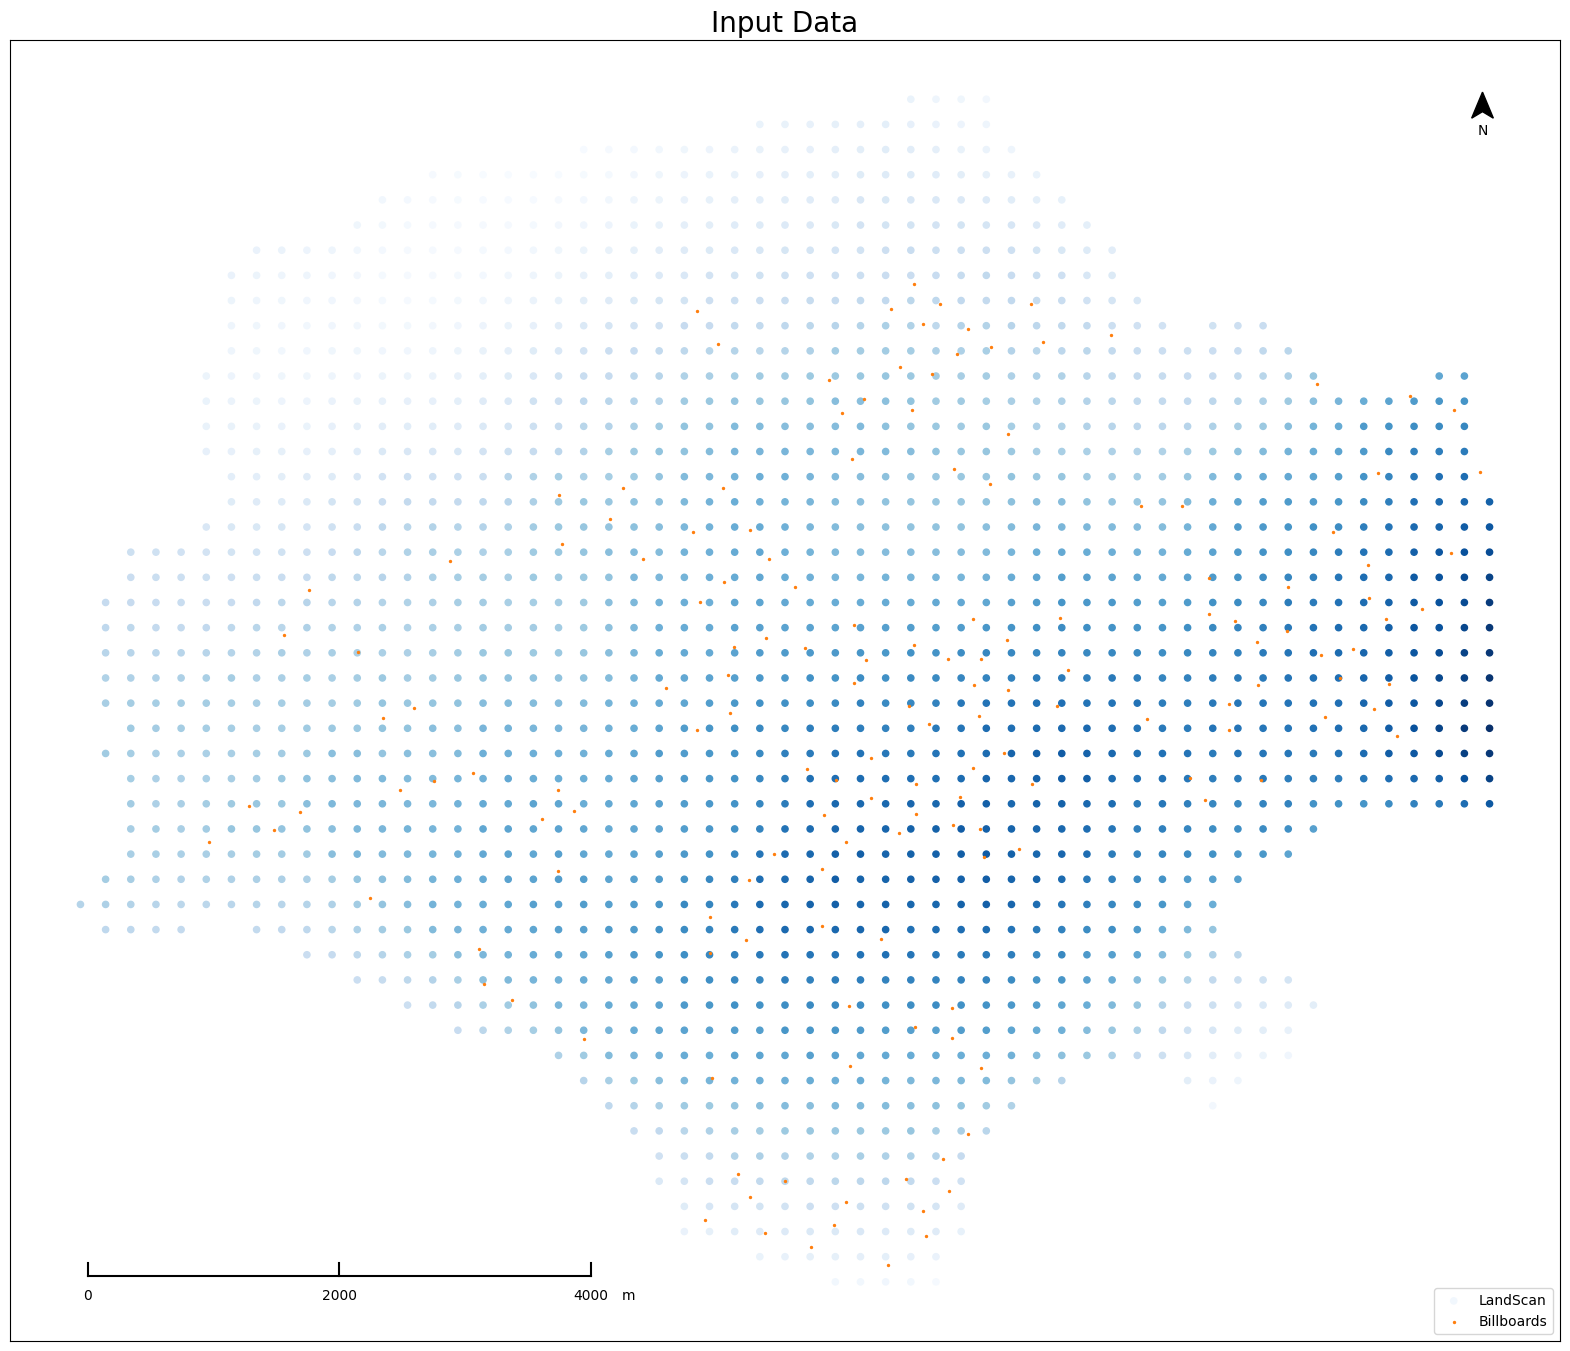

In [15]:
%%time
fig, ax = plt.subplots(figsize=(20,18))

ls.plot(ax = ax, column=ls['demand'], k=5, markersize=20, cmap='Blues', label = 'LandScan')
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [16]:
def generate_candidate_sites(sites, M=100, heuristic=None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

# LandScan sites =1109, Billboard sites=839, R=2000 M=20

In [17]:
def gen_real_data(ls, num_sample):
    real_datasets = []
    for i in range(num_sample):
        bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")
        real_data = {}
        real_data["users"] = torch.tensor(np.array(ls[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data["facilities"] = torch.tensor(np.array(bbs_[['NORM_X', 'NORM_Y']])).to(torch.float32)
        real_data['demand'] = torch.tensor(np.array(ls['demand'])).to(torch.float32)
        real_data["p"] = 30
        real_data["r"] =500/S
        real_datasets.append(real_data)
    return bbs_, real_datasets

In [18]:
num_sample = 1
opts.eval_batch_size = 10
opts.max_calc_batch_size = 1280000
width = 128
bbs_, real_datasets = gen_real_data(ls, num_sample)

In [19]:
from torch.utils.data import DataLoader
from tqdm import tqdm
opts.decode_strategy = 'sampling'
model.eval()
model.set_decode_type(
    "greedy" if opts.decode_strategy in ('bs', 'greedy') else "sampling")
dataloader = DataLoader(real_datasets, batch_size=opts.eval_batch_size)


In [26]:
start = time.time()
results = []
for batch in tqdm(dataloader, disable=True):
    batch = move_to(batch, opts.device)
    start = time.time()
    with torch.no_grad():
        if opts.decode_strategy in ('sampling', 'greedy'):
            if opts.decode_strategy == 'greedy':
                assert width == 0, "Do not set width when using greedy"
                assert opts.eval_batch_size <= opts.max_calc_batch_size, \
                    "eval_batch_size should be smaller than calc batch size"
                batch_rep = 1
                iter_rep = 1
            elif width * opts.eval_batch_size > opts.max_calc_batch_size:
                assert opts.eval_batch_size == 1
                assert width % opts.max_calc_batch_size == 0
                batch_rep = opts.max_calc_batch_size
                iter_rep = width // opts.max_calc_batch_size
            else:
                batch_rep = width
                iter_rep = 1
            assert batch_rep > 0
            # This returns (batch_size, iter_rep shape)

            sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
            batch_size = len(costs)
            ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)
#         else:
#             # assert opts.decode_strategy == 'bs'

#             cum_log_p, sequences, costs, ids, batch_size = model.beam_search(
#                 batch, beam_size=width,
#                 compress_mask=opts.compress_mask,
#                 max_calc_batch_size=opts.max_calc_batch_size
#             )
            if sequences is None:
                sequences = [None] * batch_size
                costs = [math.inf] * batch_size
            else:
                sequences, costs = get_best(
                    sequences.cpu().numpy(), costs.cpu().numpy(),
                    ids.cpu().numpy() if ids is not None else None,
                    batch_size
                )
            duration = time.time() - start
            for seq, cost in zip(sequences, costs):
                seq = seq.tolist()
                results.append((cost, seq, duration))
costs, tours, durations = zip(*results)
print(f"The objective of MCBLP by DRL is: {-costs[0]}")
end = time.time()-start 
print(f"The running time of DRL is: {end}")

The objective of MCBLP by DRL is: 258.24755859375
The running time of DRL is: 0.29003357887268066


In [27]:
def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

In [30]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20, 15))
    ls.plot(ax=ax, column=ls['demand'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Cabinets')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=10,
                           label='Optimized Selected Cars')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m' + ' by DRL'
    ax.set_title(title, fontsize=40)
    render_scale_bar(ax=ax, x=0.05, y=0.05)
    render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    ax.legend(loc='lower right', markerscale=4, fontsize=20)
    return ax

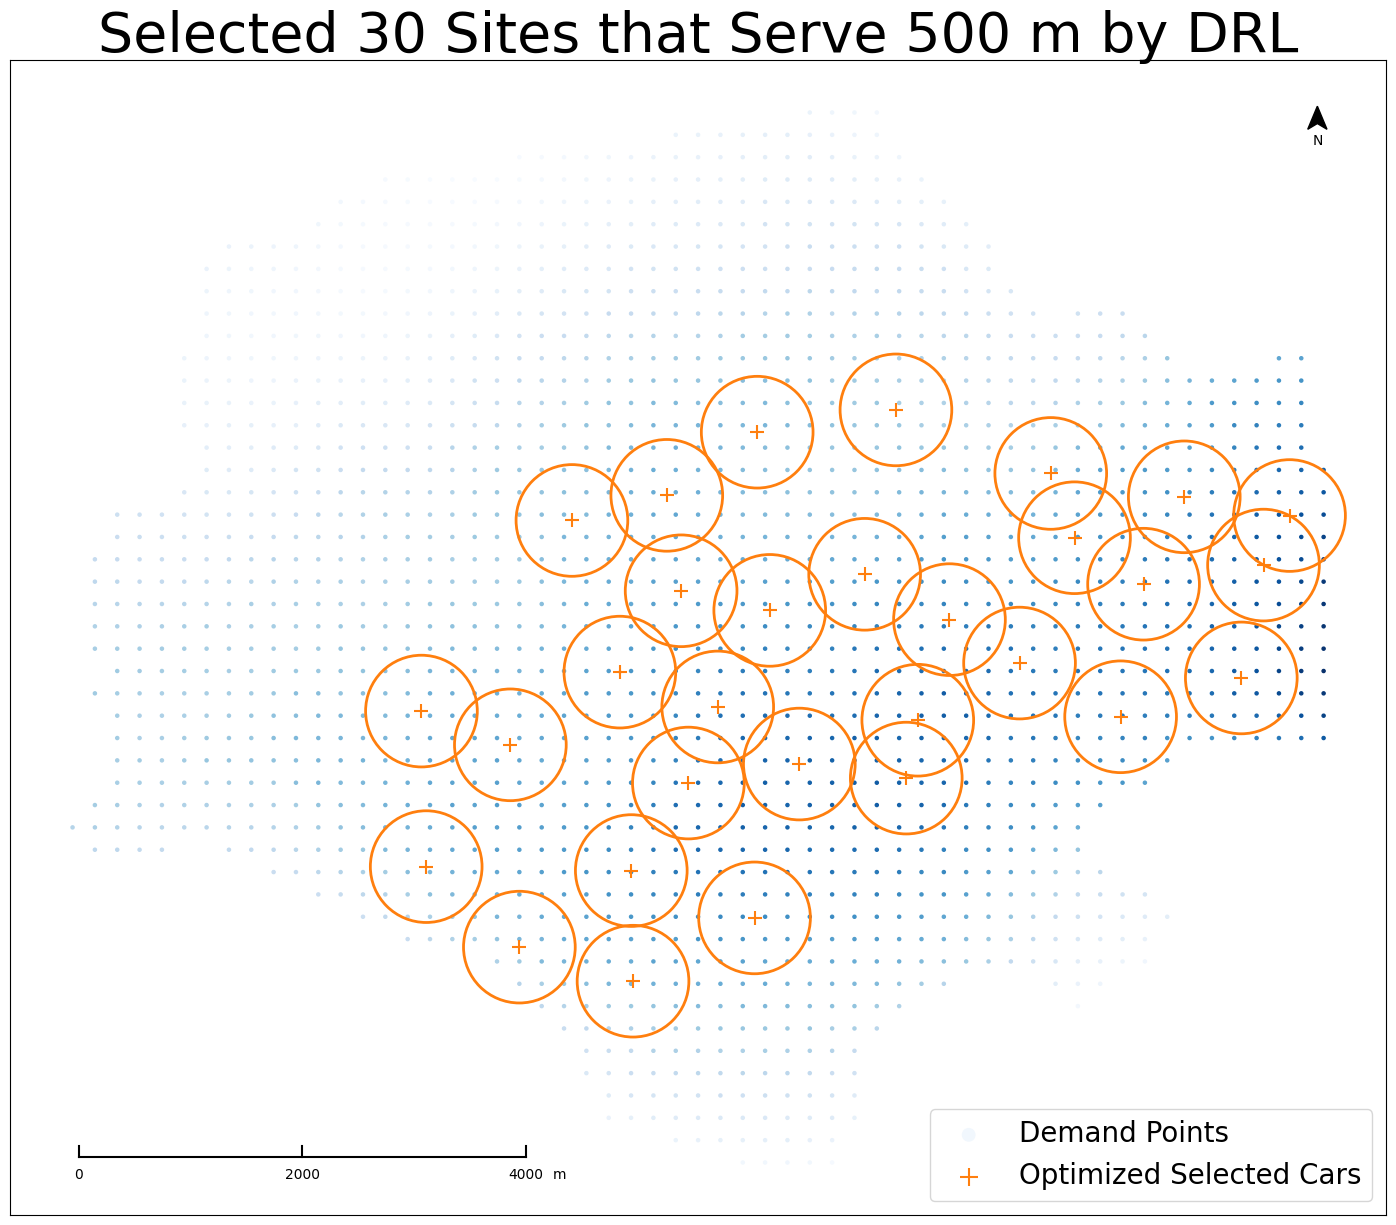

In [31]:
opt_sites = bbs_.iloc[tours]
plot_result(ls,opt_sites,500)
plt.savefig('./picture/SpoNet_epoch53_MCLP.jpg', dpi=600)
plt.show()